**MULTI LABEL GENRE CLASSIFICATION**

<!--
PROBLEM STATEMENT:

Create a multi-label genre classification model using Tensorflow that automatically
assigns genre names looking at the summary of the movie.
1. Use pre-built embeddings for your data dictionary
2. Train the model using Transformer/Attention based architecture
3. Reach an overall “precision” score of 70%
4. Use TF serving to deploy the model as an API (on local)
5. Build a TF serving client to interact with the API. This client should also be able
to continuously accept data entered by the user and provide the genre for the
chat entered by the end-user.
-->

#IMPORTING NECESSARY LIBRARIES AND PACKAGES

In [1]:
#Installing transformers package
!pip install transformers -q

     |████████████████████████████████| 5.3 MB 24.2 MB/s 
     |████████████████████████████████| 163 kB 63.6 MB/s 
     |████████████████████████████████| 7.6 MB 65.4 MB/s 


In [7]:
import transformers

In [2]:
#Installing tensorflow-text package
!pip install tensorflow_text -q

     |████████████████████████████████| 5.9 MB 32.0 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 1.7 MB 62.3 MB/s 
     |████████████████████████████████| 5.9 MB 60.9 MB/s 
     |████████████████████████████████| 438 kB 57.5 MB/s 


In [3]:
#Importing all required libraries
import tempfile
import pandas as pd
import numpy as np
import json
import nltk
import re
import os
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#LOADING DATASET

In [12]:
#downloading the dataset using wget command

!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2022-10-26 08:16:33--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M  7.23MB/s    in 6.4s    

2022-10-26 08:16:44 (7.13 MB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]



In [13]:
#Extracting the gzip file

!tar -xvzf MovieSummaries.tar.gz

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


From the above directory we have the following files:

- tvtropes.clusters.txt
- name.clusters.txt
- plot_summaries.txt
- README.txt
- movie.metadata.tsv
- character.metadata.tsv

But we require only 2 files:

- movie.metadata.tsv
- plot_summaries.txt

Reading the movie.metadata.tsv file

In [14]:
# This are the columns in move.metadata.tsv file

movie_metadata_columns = [  "Wikipedia movie ID",
                            "Freebase movie ID",
                            "Movie name",
                            "Movie release date",
                            "Movie box office revenue",
                            "Movie runtime",
                            "Movie languages",
                            "Movie countries",
                            "Movie genres" ]


#reading the data

movie_metadata = pd.read_csv('/content/MovieSummaries/movie.metadata.tsv' , sep='\t' , names = movie_metadata_columns)

In [15]:
#Dropping the unwanted columns from the dataframe

movie_metadata = movie_metadata.drop(columns = [  "Freebase movie ID",
                                                  "Movie name",
                                                  "Movie release date",
                                                  "Movie box office revenue",
                                                  "Movie runtime",
                                                  "Movie languages",
                                                  "Movie countries",   ])


movie_metadata.head()

,Wikipedia movie ID,Movie genres
0,975900,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,"{""/m/07s9rl0"": ""Drama""}"


In [16]:
# The movie genres column has the data of the genres but in an unorganized way and we will clean it

movie_metadata["Movie genres"] = movie_metadata["Movie genres"].map(lambda genres: list(eval(genres).values()))

movie_metadata.head()

,Wikipedia movie ID,Movie genres
0,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,"[Crime Fiction, Drama]"
3,9363483,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,[Drama]


Reading the plot_summaries file

In [17]:
plot_summaries = pd.read_csv('/content/MovieSummaries/plot_summaries.txt',
                             sep='\t' , names = ["Wikipedia movie ID","Summary"])

plot_summaries.head()

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [18]:
#Merging the both dataframes

dataset = pd.merge(movie_metadata,plot_summaries,on="Wikipedia movie ID")

dataset.head()

,Wikipedia movie ID,Movie genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


#DATA CLEANING

In [19]:
#Lowercasing all the plot summaries

dataset["Summary"]=dataset["Summary"].str.lower()

In [20]:
#Finding the unique geners

genres = dataset["Movie genres"].explode().unique().tolist()

print('Total No.of unique genres in the dataset are :' , len(genres))

Total No.of unique genres in the dataset are : 364


In [21]:
dataset.head()

,Wikipedia movie ID,Movie genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",a series of murders of rich young women throug...
2,261236,[Drama],"eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","every hundred years, the evil morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","adam, a san francisco-based artist who works a..."


In [22]:
#As we don't need the wikipedia movie ID column we are gonna remove it

dataset = dataset.drop('Wikipedia movie ID', axis=1)

# Turning the genres list column to there own respective column 

dataset = dataset.drop('Movie genres', 1).join(dataset["Movie genres"].str.join('|').str.get_dummies())

dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


,Summary,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,"set in the second half of the 22nd century, th...",0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Getting all the genres name

genres_name = dataset.columns
genres_name = genres_name[1:]
genres_name = list(genres_name)

In [24]:
# defining a function to drop column with low count of data based on a certain threshold

def deleteData(dataset,genres_name,threshold):

  for name in genres_name:

    if dataset[name].value_counts()[1] <= threshold:
        dataset=dataset.drop(name , axis = 1)

  return dataset

In [25]:
dataset = deleteData(dataset,genres_name,30)

In [26]:
dataset.head()

,Summary,Absurdism,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,Adventure Comedy,...,Tollywood,Tragedy,Tragicomedy,War film,Western,Whodunit,Workplace Comedy,World cinema,Wuxia,Zombie Film
0,"set in the second half of the 22nd century, th...",0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
 #Getting all the genres name

genres_name = dataset.columns
genres_name = genres_name[1:]
genres_name = list(genres_name)

In [28]:
# Num of genres

num_classes=len(genres_name)

In [29]:
# Performing one hot encoding and getting a single column with all genres data and dropping the genres column

dataset['label'] = dataset[dataset.columns[1:]].values.tolist()
dataset = dataset[['Summary', 'label']].copy()

In [30]:
dataset.head()

,Summary,label
0,"set in the second half of the 22nd century, th...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,a series of murders of rich young women throug...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"eva, an upper class housewife, becomes frustra...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"every hundred years, the evil morgana returns...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,"adam, a san francisco-based artist who works a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
# defining functions for cleaning the text of plot summaries


def clean(sentence):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr, ' ', str(sentence))
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',cleaned)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")

    return cleaned

In [32]:
#Applying the functions to the dataset

dataset['Summary'] = dataset['Summary'].apply(clean)


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42204 entries, 0 to 42203
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  42204 non-null  object
 1   label    42204 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [34]:
# Converting Summary column datatype from object to String

dataset=dataset.convert_dtypes()

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42204 entries, 0 to 42203
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  42204 non-null  string
 1   label    42204 non-null  object
dtypes: object(1), string(1)
memory usage: 2.0+ MB


In [35]:

# Spliting the dataset into train and test of 80:20 Ratio

train = dataset.sample(frac=0.8)

test = dataset.drop(train.index)

In [36]:
train.head()

,Summary,label
40926,joe parker a journalist claims that he needs...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2644,in a dark and decadent city sean fallon - a c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18214,donald is taking a tour of the grand canyon a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3619,humphrey the bear oversleeps through the openi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1795,the film opens on rachel and hectors wedding...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
test.head()

,Summary,label
0,set in the second half of the 22nd century th...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
10,jimmy [[hiroshi watanabe loves dinosaurs and...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15,mary an orphan lives in an orphanage run by n...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19,archie andrews fifteen years after graduating...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27,chandra mukhi a princess of a heavenly kingd...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [38]:
#Converting list into tensorflow objects

train_list = train["Summary"].to_list()
test_list = test["Summary"].to_list()

ytrain_list = train["label"].to_list()
ytest_list = test["label"].to_list()

train_ds = tf.data.Dataset.from_tensor_slices((train_list,ytrain_list))
test_ds = tf.data.Dataset.from_tensor_slices((test_list,ytest_list))

# Creating batch and shuffling the data

train_ds = train_ds.shuffle(10000).batch(32, drop_remainder=True)
test_ds = test_ds.shuffle(10000).batch(32, drop_remainder=True)

#MODEL BUILDING

Here we are using bert pretrained model

In [ ]:
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

encoder = hub.KerasLayer('https://tfhub.dev/google/experts/bert/wiki_books/sst2/2' , trainable = False)

Model architecture

In [ ]:
#Input are embedding layers

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)

#Fully connected layers

l = tf.keras.layers.Dense(1000, activation='relu')(outputs['pooled_output'])
l = tf.keras.layers.Dense(800, activation='relu')(l)
l = tf.keras.layers.Dense(600, activation='relu')(l)
l = tf.keras.layers.Dense(400, activation='relu')(l)
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output")(l)

#Constructing final model

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
#model summary

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
#Defining metrics

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision')
]


#reduce le callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
          monitor = 'precision',
          factor = 0.1,
          patience = 3,
          mode = 'auto',
          min_delta = 0.005,
          min_lr = 0.0001
      )



#Compiling the model


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
#Training the model

history = model.fit(train_ds , validation_data = test_ds , batch_size = 512,
                    callbacks = [reduce_lr] , epochs = 20)

Epoch 1/20
1055/1055 [==============================] - 446s 412ms/step - loss: 0.0610 - accuracy: 0.9819 - precision: 0.4984 - val_loss: 0.0551 - val_accuracy: 0.9831 - val_precision: 0.6548 - lr: 0.0010
Epoch 2/20
1055/1055 [==============================] - 442s 419ms/step - loss: 0.0532 - accuracy: 0.9835 - precision: 0.6313 - val_loss: 0.0528 - val_accuracy: 0.9835 - val_precision: 0.6567 - lr: 0.0010
Epoch 3/20
1055/1055 [==============================] - 435s 412ms/step - loss: 0.0514 - accuracy: 0.9837 - precision: 0.6426 - val_loss: 0.0521 - val_accuracy: 0.9836 - val_precision: 0.6470 - lr: 0.0010
Epoch 4/20
1055/1055 [==============================] - 438s 415ms/step - loss: 0.0501 - accuracy: 0.9839 - precision: 0.6526 - val_loss: 0.0511 - val_accuracy: 0.9838 - val_precision: 0.6735 - lr: 0.0010
Epoch 5/20
1055/1055 [==============================] - 433s 411ms/step - loss: 0.0466 - accuracy: 0.9845 - precision: 0.6836 - val_loss: 0.0497 - val_accuracy: 0.9841 - val_precis

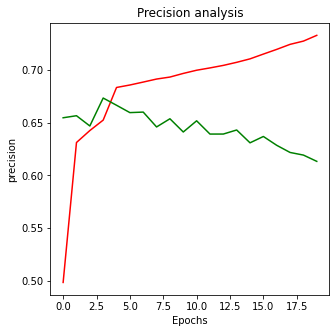

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(history.history['precision'], 'r')
plt.plot(history.history['val_precision'], 'g')
plt.title('Precision analysis')
plt.xlabel('Epochs' )
plt.ylabel('precision' )
plt.show()

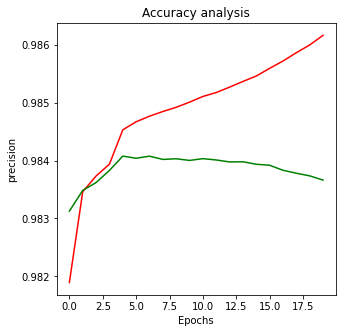

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'g')
plt.title('Accuracy analysis')
plt.xlabel('Epochs' )
plt.ylabel('precision' )
plt.show()

In [ ]:
model.save('capstone-model-siddarth.h5')

In [43]:
#Defining a function to get genres name from model predicted value

def genre_predictor(prediction):
  prediction_dict = {}
 
  #creating a dictionory of prediction and class name
  for i,p in enumerate(prediction):
    prediction_dict[genres_name[i]] = p

  genres = []

  #Filtering the dictionary to get only the intents that are above the threshold
  for key,value in prediction_dict.items():

    if value > 0.2:
      genres.append(key)

  #Converting those filtered dictionary keys to text
  text = 'predicted genres are: '

  for i in genres:
    text += i + ","

  return text


In [ ]:
pred = model.predict(test_list[:3])

1/1 [==============================] - 1s 859ms/step


In [ ]:
genre_predictor(pred[0])

'predicted genres are: Action,Adventure,Animation,Comedy,Family Film,Science Fiction,Short Film,'

#SAVING MODEL

In [ ]:
MODEL_DIR = tempfile.gettempdir()

# version of model to be save
version = 1


# path to export
export_path = os.path.join(MODEL_DIR , str(version))

# if already present model in path than remove it and save again
if os.path.isdir(export_path):
  print('\n Already saved the model , cleaning up \n')
  !rm -r {export_path}

# saving the model
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 11068
drwxr-xr-x 2 root root     4096 Oct 26 07:03 assets
-rw-r--r-- 1 root root    16713 Oct 26 07:03 keras_metadata.pb
-rw-r--r-- 1 root root 11303836 Oct 26 07:03 saved_model.pb
drwxr-xr-x 2 root root     4096 Oct 26 07:03 variables


In [ ]:
#Saving model to Gdrive
google_model_dir = "/content/Gdrive/MyDrive/capstone-model"

version = 1

google_export_path = os.path.join("/content/Gdrive/MyDrive/capstone-model", str(version))

tf.keras.models.save_model(
    model,
    google_export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

In [5]:
google_model_dir = "/content/gdrive/MyDrive/capstone-model"

In [ ]:
!saved_model_cli show --dir {export_path} --all

#TF SERVING (LOCAL)

In [6]:
import sys
import os
import json
import requests

# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'


else:
  SUDO_IF_NEEDED = ''

In [7]:
#Installing tensorflow model server

!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2022-10-26 08:14:22--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 172.253.63.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M  5.13MB/s    in 61s     

2022-10-26 08:15:23 (5.23 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpa

In [8]:
# creating environment variables

os.environ["MODEL_DIR"] = google_model_dir



In [9]:
#Starting the server

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=multilabel_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [10]:
#Checking log files

!tail server.log

In [39]:
# Creating a json object for  requests

data = json.dumps({
    'signature_name' : 'serving_default',
    'instances' : test_list[:3]
})

In [40]:
#Getting Predictions

headers = {'content-type' : 'application/json'}

json_response = requests.post('http://localhost:4000/v1/models/multilabel_model:predict',
                              data = data , headers = headers)

predictions = json.loads(json_response.text)['predictions']

In [44]:
genre_predictor(predictions[1])

'predicted genres are: Comedy,Romance Film,Romantic comedy,'

#TF SERVING (CLIENT)

Client app is made using Flask and port forwading is done using ngrok

The Code is uploaded to [github_repo](https://github.com/SIDDU-0406/Capstone-project)

In [45]:
# Clonning the repo

!git clone https://github.com/SIDDU-0406/Capstone-project

Cloning into 'Capstone-project'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [46]:
# exporting the class name as pickel file for use in flask app

import pickle
pickle.dump(genres_name, open('labels.pkl', 'wb'))

In [47]:
#Installing the ngrok package

!pip install flask_ngrok pyngrok==4.1.1 -q

In [48]:
# Adding authtoke for ngrok

!ngrok authtoken 2GFUxyDgG2I4Y4N5vJctQg8vXqQ_5UfeWFuUF2kUzRv46aJXZ

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# Adding authtoke for ngrok

!ngrok authtoken 2GcemKW5qLgkM0qkCa3chQUfWgt_2rVYDWXYDKJ2Zu5Mbphph

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# Setting environmet variables for use in app

os.environ["MODEL_DIR"] = MODEL_DIR

os.environ['pred_threshold']="0.15"

In [77]:
#Starting the server

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=multilabel_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [78]:
#Checking log files

!tail server.log

In [49]:
#Running the chatbot
#Open the ngrok link to view in browser

!python /content/Capstone-project/app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Running on http://dd61-35-221-35-143.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
127.0.0.1 - - [26/Oct/2022 08:18:20] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Oct/2022 08:18:20] "GET /static/styles/style.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Oct/2022 08:18:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [26/Oct/2022 08:18:28] "GET /get?msg=Comedy%20film%0A HTTP/1.1" 200 -


#CLIENT APP screenshots

- Here we have given the 'before sunrise' movie plot summary to the chatbot
- It replies with the predicted genres

In [ ]:
from PIL import Image

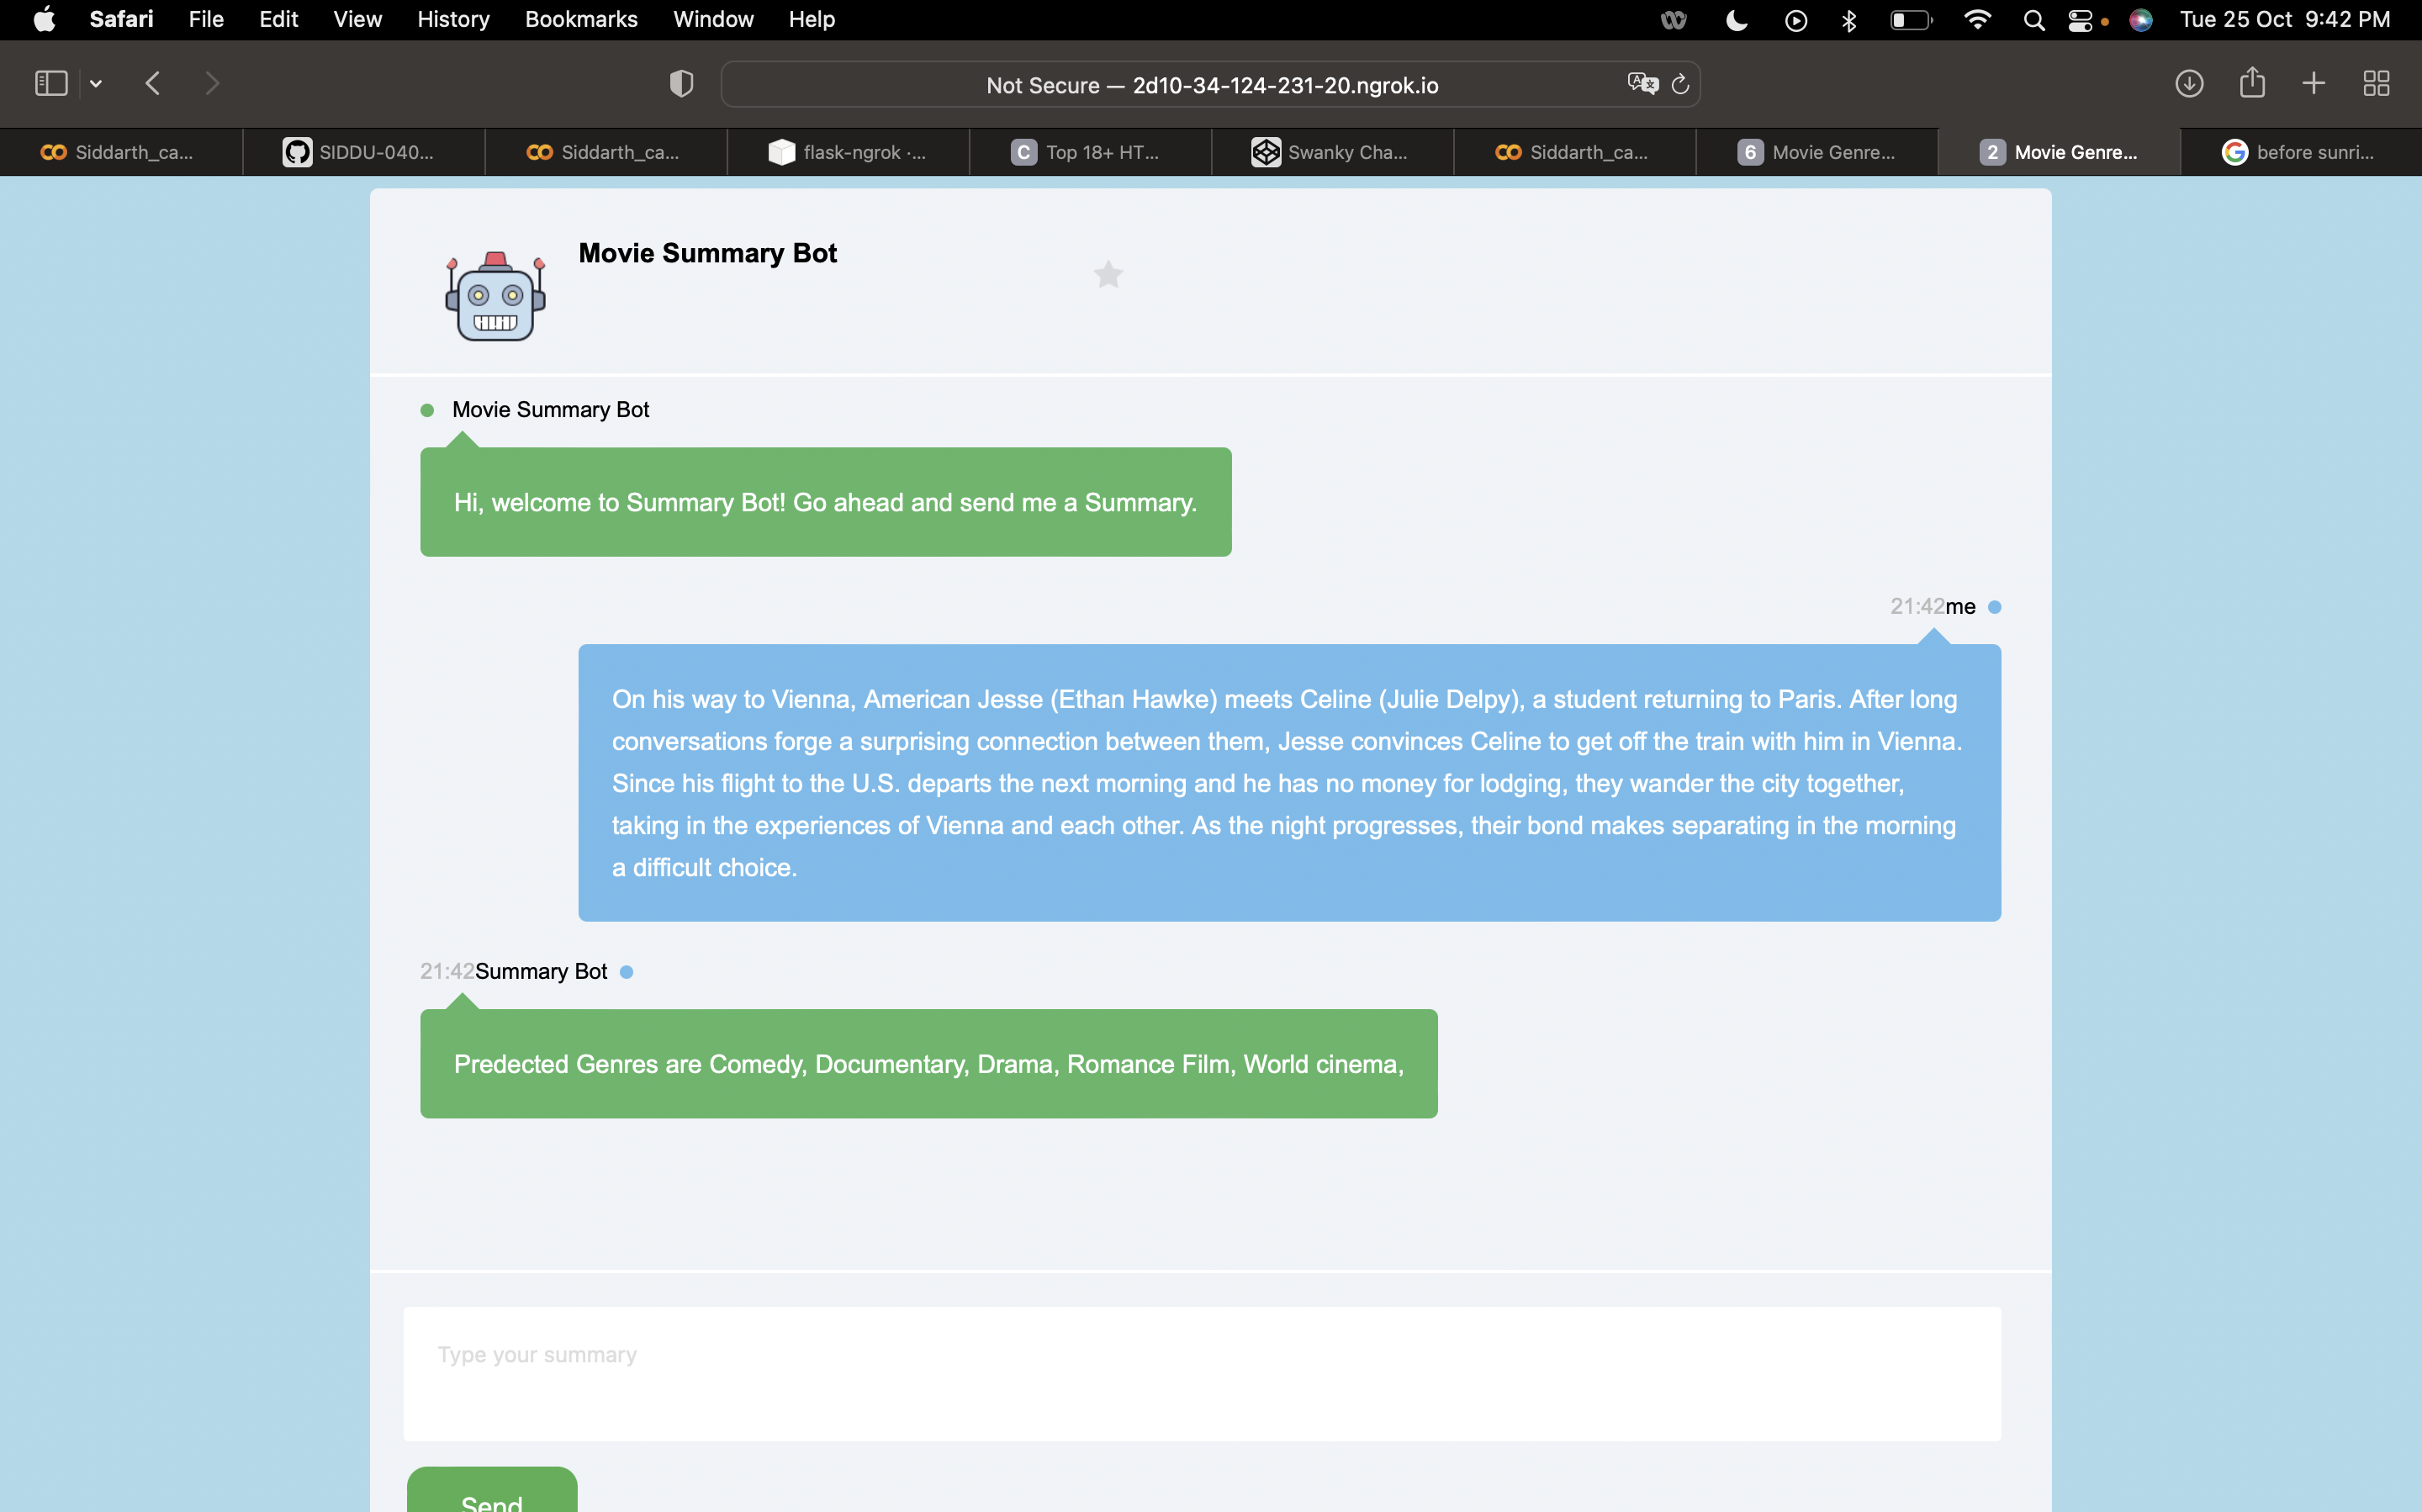

In [ ]:
Image.open('/content/Screenshot 2022-10-25 at 9.42.44 PM.png')

#CONCLUSIONS

- Firstly we have used the experts/bert pretrained model for our multi label genre prediction model

- We achieved 98.67% accuracy and 73.37% precision through our model as we have expected our model to perform

- Then we have used TF-Serving for deploying the model in local

- For Building a TF serving client to interact with the API we have used flask to create a web application chatbot and did port forwarding using ngrok

- The ngrok application makes our locally-hosted web server appear to be hosted on a subdomain of ngrok.com 